In [2]:
import MetaTrader5 as mt5
from datetime import datetime
import pandas as pd
import talib as ta
import time
# import schedule
import pytz
# Import Matplotlib's `pyplot` module as `plt`
import matplotlib.pyplot as plt

In [12]:
import matplotlib.pyplot as plt

In [125]:
import MetaTrader5 as mt5
from datetime import datetime
import pandas as pd
import talib as ta
# import time
# import schedule
import pytz
# Import Matplotlib's `pyplot` module as `plt`
# import matplotlib.pyplot as plt

import Util
import Utils


# Main variables
time_frame = mt5.TIMEFRAME_M15
time_frame_big = mt5.TIMEFRAME_H1
# symbol = "AUDNZD"
# symbol = "USDCAD"

symbol = "AUDJPY"


if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())


df = get_data(symbol, time_frame)
df_big = get_data(symbol, time_frame_big)

print("GET DATA DONE")

df = add_orders(df, df_big)
print("ADD ORDERS DONEE")

df = add_exec_prices(df)
print("ADD EXEC PRICES DONE")

df = add_calculations(df)
print("ADD CALCULATIONS")


print("return :", df.Return.sum())

print("POS :", df.pos.sum())

print("NEG :", df.neg.sum())

print("SUM of POS and NEG = ",df.pos.sum() + df.neg.sum())

df.to_excel("excel/AUDJPY_2months.xlsx", sheet_name='Sheet 1')



print("JOB IS DONEE")

"""
get_data
add_orders
add_exec_prices
add_calculations

"""

GET DATA DONE
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'buy - closing short position', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'sell - closing long position', None, None, None, None, None, None, None, None, None, None, None, 'buy - closing short position', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'sell - closing long position', None, None, None, None, None,

54
122
123
ADD EXEC PRICES DONE
ADD CALCULATIONS
return : 1.8350000000000648
POS : 11.38500000000002
NEG : -9.549999999999955
SUM of POS and NEG =  1.8350000000000648
JOB IS DONEE


'\nget_data\nadd_orders\nadd_exec_prices\nadd_calculations\n\n'

In [7]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread',
       'real_volume', 'change', '8ema', '13ema', '21ema', 'exec', 'exec_buy',
       'exec_sell', 'exec_close', 'Highest', 'Lowest', 'Return', 'P/L',
       'Open Position Price', 'pos', 'neg', 'highest percentgge change',
       'lowest percentage change', 'close percentage change'],
      dtype='object')

In [15]:
df

,time,open,high,low,close,tick_volume,spread,real_volume,change,8ema,...,Highest,Lowest,Return,P/L,Open Position Price,pos,neg,highest percentgge change,lowest percentage change,close percentage change
0,2021-05-31 20:00:00,1.20672,1.20728,1.20652,1.20660,758,2,0,0.00012,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-05-31 20:15:00,1.20660,1.20711,1.20654,1.20684,851,2,0,-0.00024,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-05-31 20:30:00,1.20683,1.20712,1.20658,1.20678,687,2,0,0.00005,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-05-31 20:45:00,1.20677,1.20710,1.20654,1.20683,676,3,0,-0.00006,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-05-31 21:00:00,1.20682,1.20697,1.20649,1.20667,379,2,0,0.00015,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4216,2021-07-30 22:45:00,1.24729,1.24797,1.24693,1.24797,973,2,0,-0.00068,1.247690,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4217,2021-07-30 23:00:00,1.24796,1.24803,1.24698,1.24770,476,2,0,0.00026,1.247692,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4218,2021-07-30 23:15:00,1.24770,1.24797,1.24734,1.24734,232,3,0,0.00036,1.247614,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4219,2021-07-30 23:30:00,1.24734,1.24734,1.24601,1.24623,251,2,0,0.00111,1.247307,...,1.24911,1.24463,0.00114,P,1.24509,0.00114,NaN,0.003229,-0.000369,0.000916


<AxesSubplot:>

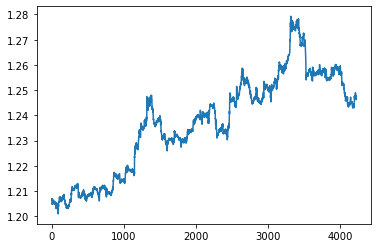

In [5]:
df['close'].plot()

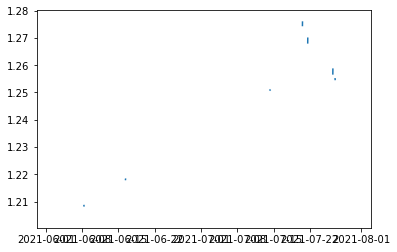

In [52]:
plt.plot(df['time'],df['close'], label= "close price")
plt.plot(df['time'],df['Open Position Price'], label= "positions")
plt.show()

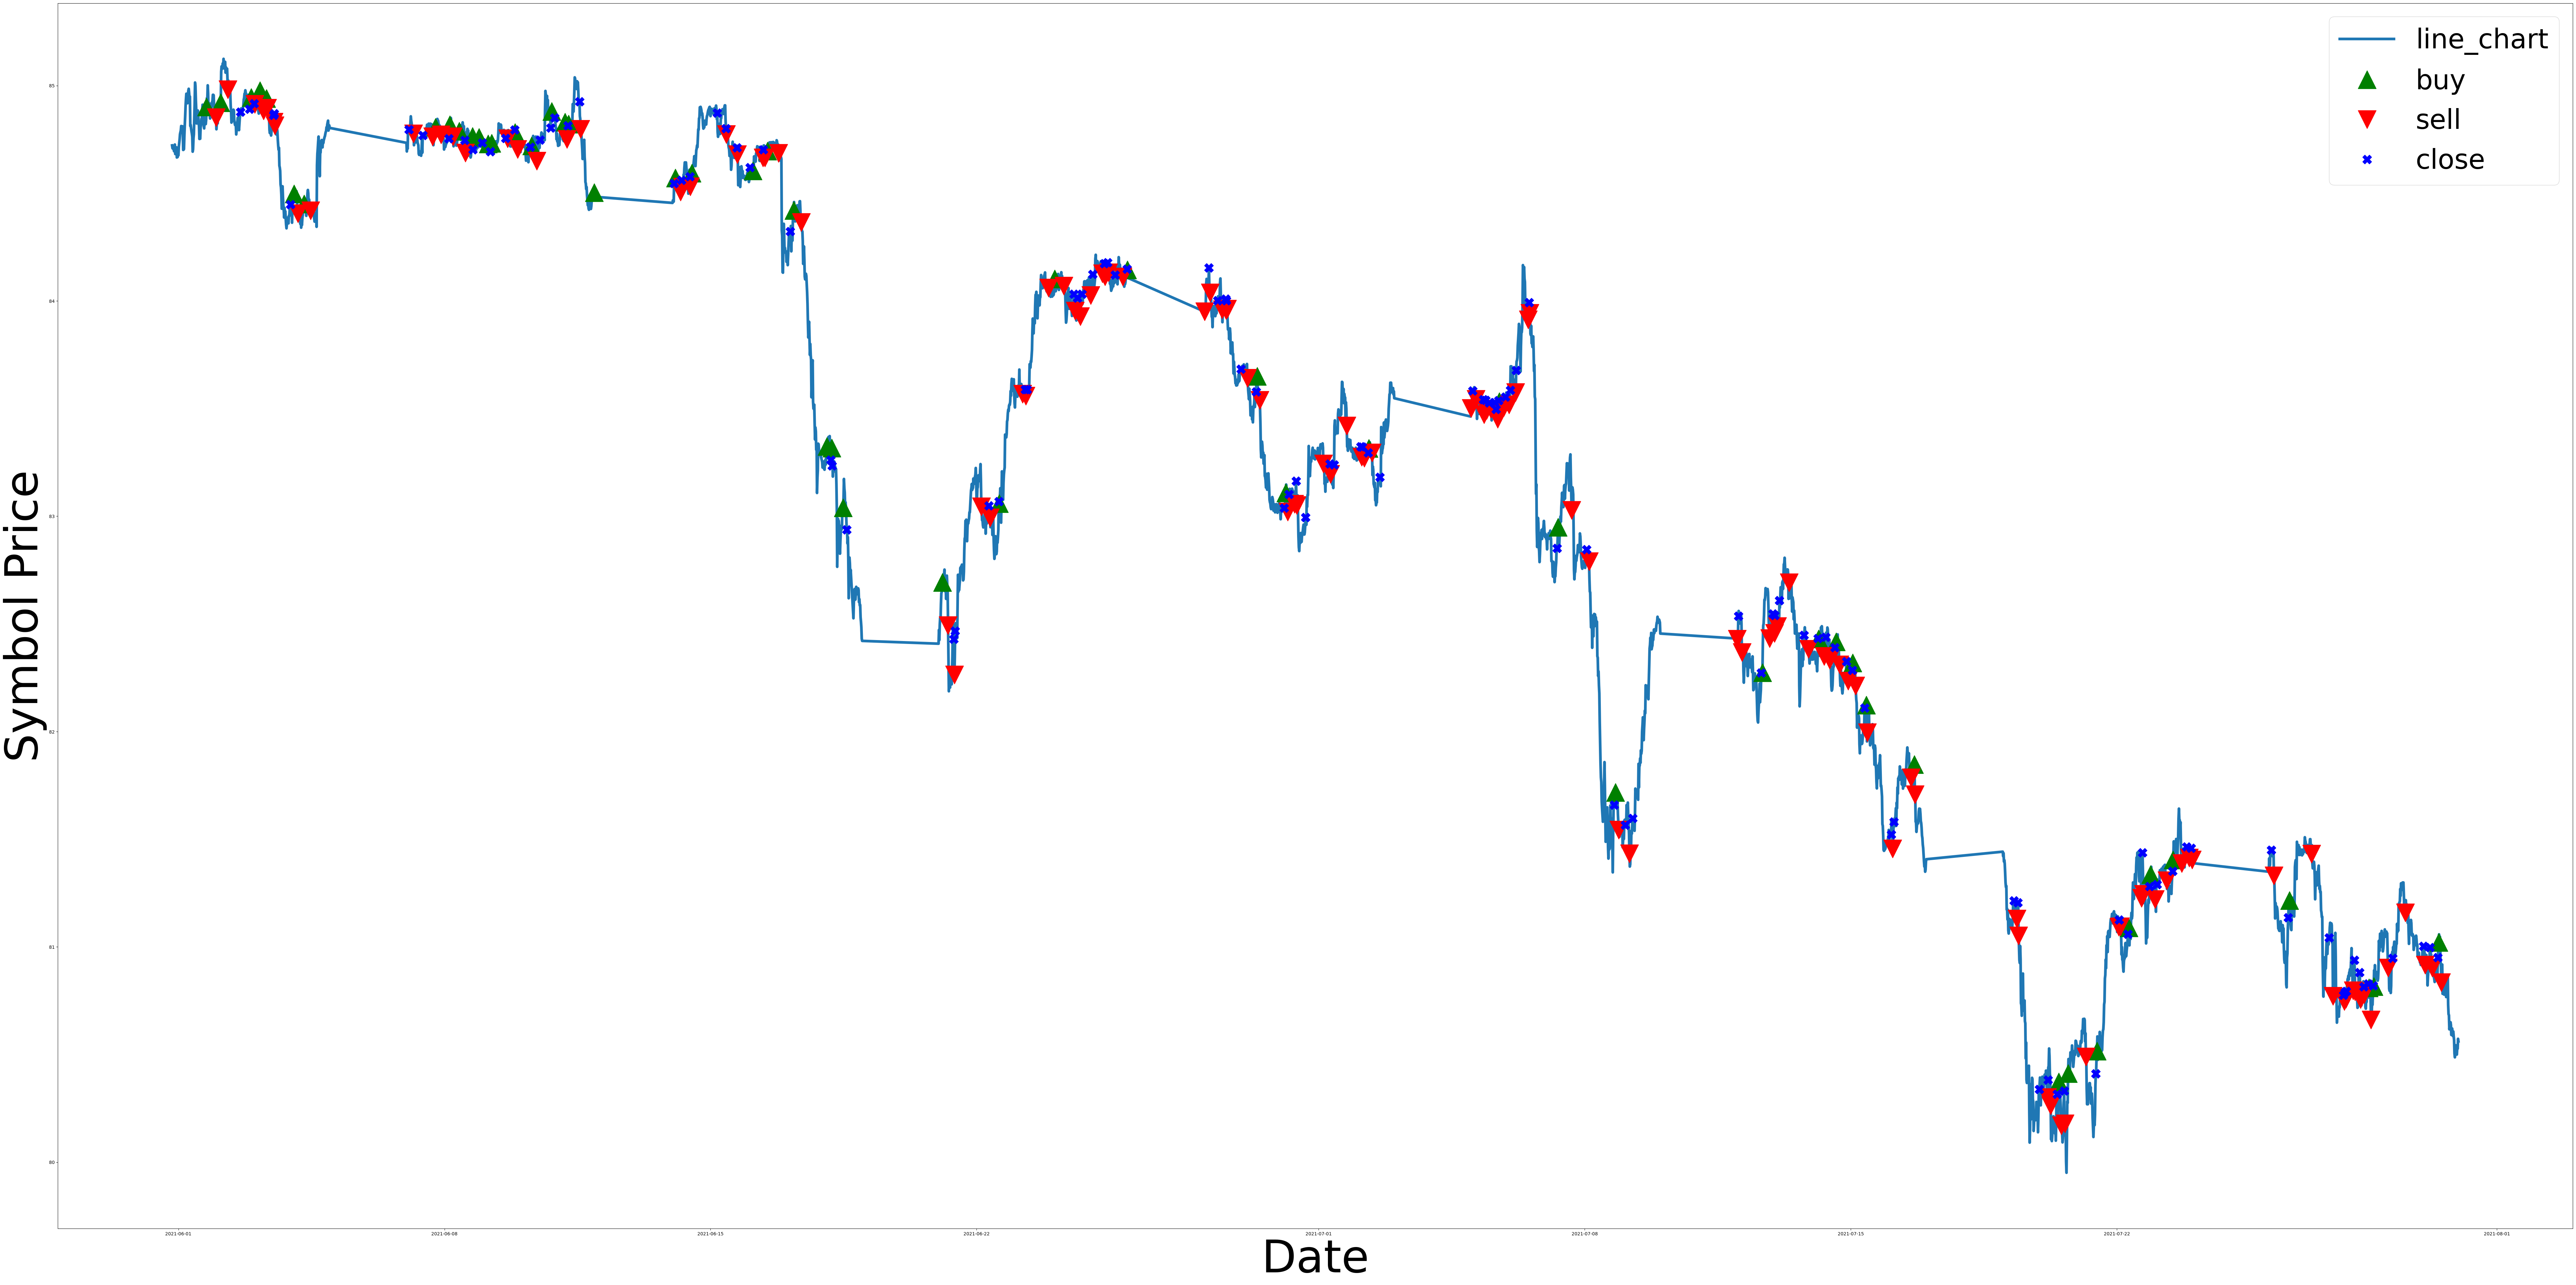

In [139]:
plt.plot(df['time'],df['close'], linewidth=6, label = "line_chart")
plt.plot(df['time'],df['exec_buy'], '^', markersize=40, color='g', label = "buy")
plt.plot(df['time'],df['exec_sell'], 'v', markersize=40, color='r', label = "sell")
plt.plot(df['time'],df['exec_close'], 'X', markersize=20, color='b', label = "close")
plt.ylabel('Symbol Price',fontsize=100)
plt.xlabel('Date',fontsize=100)
plt.legend(fontsize=60)
fig1 = plt.gcf()
plt.show()
fig1.savefig('buy-sell-chart.png', dpi=100)

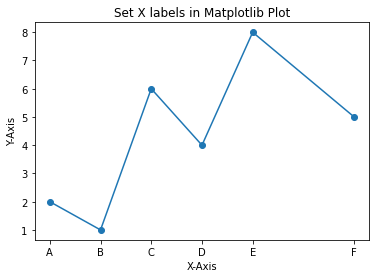

In [71]:
x=[1,2,3,4,5,7]
y=[2,1,6,4,8,5]

values = ['A', 'B', 'C', 'D','E','F'] 

plt.plot(x,y,marker="o")
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.title("Set X labels in Matplotlib Plot")
plt.xticks(x,values)
plt.show()

In [62]:
df['time']

0      2021-05-31 20:00:00
1      2021-05-31 20:15:00
2      2021-05-31 20:30:00
3      2021-05-31 20:45:00
4      2021-05-31 21:00:00
               ...        
4216   2021-07-30 22:45:00
4217   2021-07-30 23:00:00
4218   2021-07-30 23:15:00
4219   2021-07-30 23:30:00
4220   2021-07-30 23:45:00
Name: time, Length: 4221, dtype: datetime64[ns]

In [1]:
import MetaTrader5 as mt5
from datetime import datetime
import pandas as pd
import talib as ta
# import time
# import schedule
import pytz

###latest update of Util 9-20-2021


def get_data(symbol, time_frame):
    data = dict()
    utc_from = datetime(2021, 6, 1, tzinfo=pytz.timezone('Etc/GMT-4'))
    date_to = datetime(2021, 8, 1, tzinfo=pytz.timezone('Etc/GMT-4'))
    rates = mt5.copy_rates_range(symbol, time_frame, utc_from, date_to)
    df = pd.DataFrame(rates)  
    #conver teh fime column to a readable format
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
    #create the change column
    df['change'] = df.apply(lambda row: row.open - row.close, axis = 1) 
    # calculate and add EMAs to data frame
    df['8ema'] = ta.EMA(df['close'], 8)
    df['13ema'] = ta.EMA(df['close'], 13)
    df['21ema'] = ta.EMA(df['close'], 21)
    # df = add_orders(df)
    
    return df





def add_orders(df, df_big):
    # add the maker execution depending on the conditions buy and sell
    new_column = [None] * len(df["close"])  # create new column
    buy = 'buy - closing short position'
    sell = 'sell - closing long position'
    close_pos ='close pos'
    count_buy = 0
    count_sell = 0
    count_close = 0
    k = 21
    s = k*4
    df_big_len = len(df_big['close'])
    # for indexing
    last_action = ''
    for i in range(len(df["close"])):
        
        if i > s:

            if i % 4 and k != df_big_len-1:                    
                k += 1

            # print(k)
            mov_avg8_big = df_big['8ema'][k]
            mov_avg13_big = df_big['13ema'][k]
            mov_avg21_big = df_big['21ema'][k]

            trendup = mov_avg8_big >= mov_avg13_big and mov_avg13_big >= mov_avg21_big
            trenddown = mov_avg8_big <= mov_avg13_big and mov_avg13_big <= mov_avg21_big
            
            mov_avg8 = df['8ema'][i]
            mov_avg13 = df['13ema'][i]
            mov_avg21 = df['21ema'][i]
            
            low = df['low'].iloc[i]
            high = df['high'].iloc[i]
            
            mov_avg8_prev = df['8ema'][i-1]
            mov_avg13_prev = df['13ema'][i-1]
            mov_avg21_prev = df['21ema'][i-1]
            
            
            
            prev_trendup = mov_avg8_prev > mov_avg13_prev and mov_avg13_prev > mov_avg21_prev
            prev_trenddown = mov_avg8_prev < mov_avg13_prev and mov_avg13_prev < mov_avg21_prev
            
            # BUY PART
            buy_1 = (mov_avg8 > mov_avg13) and (mov_avg8_prev <= mov_avg13_prev) and trendup
            buy_2 = (mov_avg8 > mov_avg13 and mov_avg13 > mov_avg21 and low > mov_avg8) and not(mov_avg13_prev > mov_avg21_prev)# and trendup
            
            # SELL PART
            sell_1 = (mov_avg8 < mov_avg13) and (mov_avg8_prev >= mov_avg13_prev) and trenddown
            sell_2 = (mov_avg8 < mov_avg13 and mov_avg13 < mov_avg21 and high < mov_avg8) and not(mov_avg13_prev < mov_avg21_prev)# and trenddown
            
            # CLOSE POSITIONS
            close1 = (mov_avg8 > mov_avg13) and (mov_avg8_prev <= mov_avg13_prev) and trenddown
            close2 = (mov_avg8 < mov_avg13) and (mov_avg8_prev >= mov_avg13_prev) and trendup
            close = close1 or close2
            
            if (buy_1 or buy_2) and (last_action == sell or last_action == '' ) :
                last_action = buy
                new_column[i] = buy
                count_buy  +=1
                
            elif (sell_1 or sell_2) and (last_action == buy or last_action == '' ):
                last_action = sell 
                new_column[i] = sell
                count_sell +=1

            elif close:
                last_action = ''
                new_column[i] = close_pos
                count_close +=1

    print(new_column)
    df["exec"] = new_column  # add new column
    print(count_buy , ' buy orders')
    print(count_sell, ' sell orders')
    print(count_close, ' close orders')
    
    return df










def add_exec_prices(df):
    buy_column = [None] * len(df["close"])
    sell_column = [None] * len(df["close"])
    close_column = [None] * len(df["close"])
    buy = 'buy - closing short position'
    sell = 'sell - closing long position'
    close_pos ='close pos'
    count_buy = 0
    count_sell = 0
    count_close = 0
    
    for i in range(len(df["close"])):  
        if i > 21:
            if df["exec"][i] == buy :
                buy_column[i] = df["close"][i]
                count_buy +=1
                
            elif df["exec"][i] == sell:
                sell_column[i] = df["close"][i]
                count_sell +=1

            elif df["exec"][i] == close_pos:
                close_column[i] = df["close"][i]
                count_close +=1
                
            else:
                buy_column[i] = None
                sell_column[i] = None
                close_column[i] = None
        
        df['exec_buy'] = buy_column
        df['exec_sell'] = sell_column
        df['exec_close'] = close_column

    print(count_buy)
    print(count_sell)
    print(count_close)
        
    return df










def add_calculations(df):
    # add the maker execution depending on the conditions buy and sell
    highest_column = [None] * len(df["close"])  # create new column
    lowest_column = [None] * len(df["close"])  # create new column
    return_column = [None] * len(df["close"])  # create new column
    
    pos_column =  [None] * len(df["close"])  # create new column
    neg_column = [None] * len(df["close"])  # create new column
    open_pos_price = [None] * len(df["close"])  # create new column
    PnL_column = [None] * len(df["close"])  # create new column
    
    percentage_change_high = [None] * len(df["close"])  # create new column
    percentage_change_low = [None] * len(df["close"])  # create new column
    percentage_change_close = [None] * len(df["close"])  # create new column
    
    
    buy = 'buy - closing short position'
    sell = 'sell - closing long position'
    close_pos ='close pos'
    # count_buy = 0
    # count_sell = 0
    for i in range(len(df["exec"])):
        
        if i > 21:
            first_entry = 0
            # if its a long (buy to sell)
            if df["exec"][i] == buy:
                # i buy row
                high_in_between = []
                low_in_between = []
                j = i+1
                # j closing row
                while j > i:
                    high_in_between.append(df["high"][j])
                    low_in_between.append(df["low"][j])
                    
                    if df['exec'][j] == sell or df['exec'][j] == close_pos:
                        long = df["close"][i]
                        open_pos_price[j] = long

                        highest_high = max(high_in_between)
                        highest_column[j] = highest_high
                        lowest_low = min(low_in_between)
                        lowest_column[j] = lowest_low

                        # calculate profit this
                        # closing position price - buy position price
                        PnL = df["close"][j] - long
                        return_column[j] = PnL

                        # %change high = (highest - long) / long
                        percentage_change_high[j] = (highest_high - long) / long
                        # %change low = (lowest - long) / long
                        percentage_change_low[j] = (lowest_low - long) / long
                        # %change close = (close - long) / long
                        percentage_change_close[j] = PnL / long

                        if PnL > 0:
                            PnL_column[j] = "P"
                            pos_column[j] = PnL
                        elif PnL < 0:
                            PnL_column[j] = "L"
                            neg_column[j] = PnL
                        else:
                            PnL_column[j] = "neutral"
                            
                        break
                        
                    elif j == len(df["exec"])-1:
                        break
                        
                    j += 1

            
            # if its a long (buy to sell)
            if df["exec"][i] == sell:
                high_in_between = []
                low_in_between = []
                j = i+1
                while j > i:
                    high_in_between.append(df["high"][j])
                    low_in_between.append(df["low"][j])
                    
                    if df['exec'][j] == buy or df['exec'][j] == close_pos:
                        short = df["close"][i]
                        open_pos_price[j] = short

                        highest_high = max(high_in_between)
                        highest_column[j] = highest_high
                        lowest_low = min(low_in_between)
                        lowest_column[j] = lowest_low

                        # calculate profit this
                        # closing position price - buy position price
                        # profit = df["close"][j] - df["close"][i]
                        PnL = short - df["close"][j]
                        return_column[j] = PnL

                        # %change high = -(highest - short) / short
                        percentage_change_high[j] = -(highest_high - short) / short
                        # %change low = -(lowest - short) / short
                        percentage_change_low[j] = -(lowest_low - short) / short
                        # %change close = -(close - short) / short
                        percentage_change_close[j] = PnL / short

                        if PnL > 0:
                            PnL_column[j] = "P"
                            pos_column[j] = PnL
                        elif PnL < 0:
                            PnL_column[j] = "L"
                            neg_column[j] = PnL
                        else:
                            PnL_column[j] = "Na zero"
                            
                        break
                        
                    elif j == len(df["exec"])-1:
                        break
                    
                    j += 1                           
                            
    df["Highest"] = highest_column
    df["Lowest"] = lowest_column
    df["Return"] = return_column
    df["P/L"] = PnL_column
    df["Open Position Price"] = open_pos_price
    df["pos"] = pos_column
    df["neg"] = neg_column
    df["highest percentgge change"] = percentage_change_high
    df["lowest percentage change"] = percentage_change_low
    df["close percentage change"] = percentage_change_close
    
    return df